### IMPORT LIBRARIES

Start by importing the main libraries that I will need to manage the code

In [1]:
import cv2                                                  #for SIFT
import os                                                   #for read file system
import glob                                                 #for sorting files
import matplotlib.pyplot as plt                             #for plot and show images
import numpy as np                                          #for math computations
import pandas as pd                                         #for create structure of confusion matrix

from sklearn.cluster import KMeans                          #Clustering
from sklearn.metrics import accuracy_score,silhouette_score,confusion_matrix  #two metrics (accuracy, silhouette, confusion_matrix) 
from sklearn.preprocessing import MinMaxScaler, StandardScaler # two type of normalization


## First Dataset

For the first dataset I used a single image for each of the 4 themes of following figures: cow, face, car, bicycle


Start to set the folder containing the images and count the number of elements in it

In [2]:
path = "image/*"

cont=0

for file in sorted(glob.glob(path)):
    cont+=1

print("images number:",cont,"\n")

images number: 4 



I define a function that will help me to read a single image, set the color to gray and with SIFT extract the associated descriptors and keypoints.

At the end returning the pair (image_with_keypoints , descriptors)

In [3]:
def read_and_compute(image_name):
    
    #reading image and set color Gray
    img = cv2.imread(image_name)  
    color = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    #descriptors extraction
    sift = cv2.SIFT_create()
    keypoints, descriptors = sift.detectAndCompute(img,None)
    img_1 = cv2.drawKeypoints(color,keypoints,img)
    return img_1, descriptors


I define a cycle for extract each type of image, in particular from the 8 main themes, i take the themes linked to the following figures:

 - 1 -> Cows
 - 6 -> Face
 - 7 -> Car
 - 8 -> Bicycle
 
I also use the following structures to store all the necessary components:

 - data_label: stores a index for each label (0->Cows, 1->Face, 2->Car, 3->Bicicle) and its used for mapping each descriptor with their label
 - image_set: each position contains the image with the associated keypoints
 - descriptors_set: contains for each position an array with all associated descriptors 

In [4]:
data_label = []
image_set = []
descriptors_set = []
    
for file in sorted(glob.glob(path)):
    source=file

    #if the file represents a Cows 
    if file[6:7]=='1':
        im, de = read_and_compute(source)
        image_set.append(im)
        descriptors_set.append(de)
        for j in range(0,len(de)):
            data_label.append(0)

    #if the file represents a Human Face  
    if file[6:7]=='6':
        im, de = read_and_compute(source)
        image_set.append(im)
        descriptors_set.append(de)
        for j in range(0,len(de)):
            data_label.append(1)

    #if the file represents Car
    if file[6:7]=='7':
        im, de = read_and_compute(source)
        image_set.append(im)
        descriptors_set.append(de)
        for j in range(0,len(de)):
            data_label.append(2)

     #if the file represents Bicycles
    if file[6:7]=='8':
        im, de = read_and_compute(source)
        image_set.append(im)
        descriptors_set.append(de)
        for j in range(0,len(de)):
            data_label.append(3)
                

In [5]:
print("Number of image analyzed:\t", len(image_set))
print("Total set of descriptors:\t", len(descriptors_set))
print("Total descriptors:\t\t", len(data_label))

Number of image analyzed:	 4
Total set of descriptors:	 4
Total descriptors:		 2090


let's look some images

#### Cow

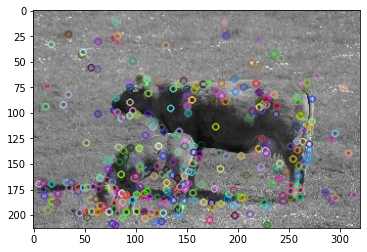

In [6]:
plt.imshow(image_set[0])

#### Face

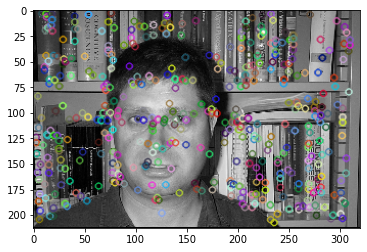

In [7]:
plt.imshow(image_set[1])

#### Car

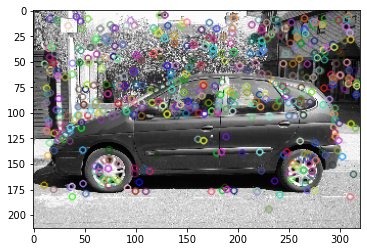

In [8]:
plt.imshow(image_set[2])

#### Bicycle

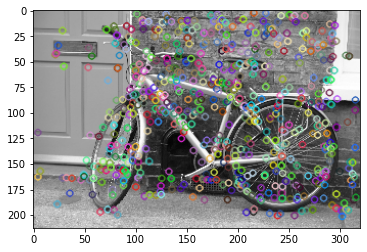

In [9]:
plt.imshow(image_set[3])

##### Trasform descriptor_set

In [10]:
descriptors_set

[array([[ 3.,  4., 68., ...,  0.,  2., 34.],
        [ 2.,  1.,  4., ...,  0.,  0.,  4.],
        [ 2.,  7., 80., ..., 12.,  5.,  8.],
        ...,
        [51., 32.,  9., ..., 17., 23., 10.],
        [ 0.,  0.,  0., ..., 15., 28., 15.],
        [ 6.,  8., 12., ...,  0.,  0.,  0.]], dtype=float32),
 array([[  0.,   0.,   0., ...,   3.,   0.,   6.],
        [ 49.,   2.,   2., ...,   0.,   0.,   0.],
        [  0.,   0.,   0., ...,  18.,  16.,  26.],
        ...,
        [  1.,   5.,   6., ...,   0.,   0.,   0.],
        [ 31.,  53., 114., ...,   8.,   1.,   1.],
        [  7.,   6.,   1., ...,  68.,  59.,   1.]], dtype=float32),
 array([[ 4.,  0.,  0., ...,  0.,  2.,  9.],
        [ 1., 27., 40., ...,  4.,  1.,  2.],
        [24.,  6.,  0., ...,  1.,  4.,  3.],
        ...,
        [22., 18.,  8., ...,  0.,  0.,  0.],
        [23.,  2.,  0., ...,  0.,  0.,  0.],
        [25.,  1.,  0., ...,  0.,  0.,  0.]], dtype=float32),
 array([[ 0.,  1., 19., ...,  0.,  0.,  0.],
        [ 0.,  0., 

Since descriptor_set is an array of 4 elements where each element contains an array representing a specific descriptor, so in total we have:

    num_image * num_descriptor_for_each_image * descriptor_values 
    
We want to transform it into an array where we have in one row the single descriptor with its associated value.

NOTE: each descriptor has the same number of columns (128), while the number of descriptors for each image can differ

In [11]:
desc=np.vstack(descriptors_set)

np.shape(desc)

(2090, 128)

### K-Means

Before clustering, normalise the data using the MinMaxScale function.

In [12]:
data= desc
scaler = MinMaxScaler()
data = scaler.fit_transform(desc)

np.shape(data)

(2090, 128)

I perform clustering using KMeans and set the number of clusters equal to 50. 

The use of Kmeans was chosen for its simplicity and for its characteristic of finding groups that are not labeled and associating each descriptor with a specific cluster to evaluate how accurate this "association" is by having different groups of descriptors


In [13]:
kmeans = KMeans(50)
kmeans.fit(data)

KMeans(n_clusters=50)

I check that the size of the labels associated with my cluster is the same as the number of rows because I want to obtain a label for each descriptor in my matrix

In [14]:
# find labels associati ad ogni descrittore
cluster_labels = kmeans.predict(data)
cluster_labels.shape

(2090,)

now cluster_labels contains for each descriptor the value of cluster that has been associated with it

In [15]:
cluster_labels[2]

46

In [16]:
#check size 
print(len(cluster_labels))
print(len(data_label))

2090
2090


In [17]:
np.unique(cluster_labels)

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49],
      dtype=int32)

### FUNCTION

I define a function that takes as input the number of labels found by kmeans and the actual labels, it create an array where each index represents the cluster associated (by kmeans) to that particular descriptor and for each cluster I take the label that appears the most. 

The function will return an array with the same size as the number of descriptors containing the value of the label which appears most in the cluster associated with the kmeans.


In [18]:
def get_kmeans_label(kmeans_label,data_label):

    dictionary_index_label = {}
    
    for i in range(len(np.unique(kmeans_label))):
        # set to 1 the positions of the elements containing that particular cluster 
        index = np.where(kmeans_label == i,1,0)
        
        # take the indices of the elements associated with the clusters
        indices = [index1 for index1, element in enumerate(index) if element == 1]
        
        # save in an array all the labels associated with the descriptors of that particular cluster
        somma = []
        for l in indices:
            somma.append(data_label[l])
            
        # count the label that appears most (it will be my reference label)
        num=np.bincount(somma).argmax()
        
        # save in the dictionary the position of cluster i which corresponds to the label found earlier
        dictionary_index_label[i] = num
    
    # dictionary_index_label is now a dictionary where each index (cluster) has the associated reference label
    
    #for each descriptor I replace the target value by the one that appears most in the cluster
    predicted_labels = np.random.rand(len(kmeans_label))
    for i in range(len(kmeans_label)):
        predicted_labels[i] = dictionary_index_label[kmeans_label[i]]
    return predicted_labels


Now i have two arrays:

- predicted_labels: contains the label associated with each descriptor by kmeans (predicted label)
- data_label: contains the true labels of each descriptor (real label)
   
at this point I compare the label that was associated by the kmeans (label that appeared most in the cluster) with the label of the actual cluster 

In [19]:
predicted_labels = get_kmeans_label(cluster_labels,data_label)

print("Classification Accuracy:", accuracy_score(predicted_labels,data_label))

cmtx = pd.DataFrame(
    confusion_matrix(predicted_labels, data_label, labels=[0, 1, 2, 3]), 
    index=['Cow', 'Face','Car','Bicycles'], 
    columns=['Cow', 'Face','Car','Bicycles']
)

print("\n",cmtx)


Classification Accuracy: 0.4244019138755981

           Cow  Face  Car  Bicycles
Cow       104    53   69        54
Face       70   202  108       116
Car        84    94  174        91
Bicycles  136   152  176       407


### Find best k and accuracy

Now, I have to find the ideal number of clusters that best classify my descriptors. 

To do this I will use three metrics:

- **Elbow** : The method consists of plotting the explained variation as a function of the number of clusters, and picking the elbow of the curve as the number of clusters to use.
- **Silouette**: Value which measure of how similar an object is to its own cluster (cohesion) compared to other clusters (separation)
- **Accuracy**: Value computes by the set of predicted labels and the corresponding set of true labels 

#### Elbow method and Silouette score


---------- k = 4  --------------
Accuracy:  0.33779904306220093
Silouette:  0.058242224

---------- k = 20  --------------
Accuracy:  0.3813397129186603
Silouette:  0.049905572

---------- k = 128  --------------
Accuracy:  0.4789473684210526
Silouette:  0.036918778

---------- k = 512  --------------
Accuracy:  0.6
Silouette:  0.04366267

---------- k = 1024  --------------
Accuracy:  0.7526315789473684
Silouette:  0.049254186


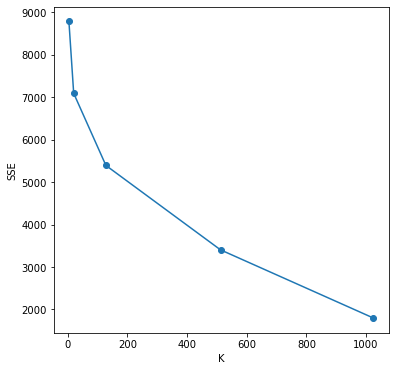

In [20]:
sse = []
list_k = [4,20,128,512,1024]

for k in list_k:
    
    km = KMeans(n_clusters=k)
    cluster_labels = km.fit_predict(data)
    
    #store the distance of the points from the cluster
    sse.append(km.inertia_)
    
    predicted_labels = get_kmeans_label(cluster_labels,data_label)
    print("\n---------- k =",k," --------------")
    print("Accuracy: ",accuracy_score(predicted_labels,data_label))
    print("Silouette: ",(silhouette_score(data, km.labels_, metric='euclidean')))
    
    
# Plot sse against k
plt.figure(figsize=(6, 6))
plt.plot(list_k, sse, '-o')
plt.xlabel(r'K')
plt.ylabel('SSE');

### Result for First Dataset

After finding the best number of k, print the final confusion matrix between the predicted and actual labels.

The confusion matrix returns a representation of statistical classification accuracy.

Each column of the matrix represents the predicted values, while each row represents the true values. The element on row i and column j is the number of instances in which the classifier classified the 'true' class i as class j. 

Through this matrix it is observable whether there is "confusion" in the classification of different classes.


In [21]:
cmtx = pd.DataFrame(
    confusion_matrix(predicted_labels, data_label, labels=[0, 1, 2, 3]), 
    index=['Cow', 'Face','Car','Bicycles'], 
    columns=['Cow', 'Face','Car','Bicycles']
)
print("\t TRUE/PREDICTED\n")
print(cmtx)

	 TRUE/PREDICTED

          Cow  Face  Car  Bicycles
Cow       326    49   56        60
Face       29   399   68        71
Car        21    18  360        49
Bicycles   18    35   43       488


## Final Analysis and Personal Consideration


The use of Kmeans proved to be useful in trying to find an association between the various types of descriptors, in particular we can note:

- **In the case of 4 images (1 image for each theme)** : we had a total of 2090 descriptors with an accuracy over 75% with 1024 clusters (equivalent to about half of the descriptors), exceeding this value certainly improves accuracy but having 1 point per cluster is not a good solution.

- **In the case of 120 images (30 image for each theme)** : the algorithm struggled a bit to find the ideal clusters, in paticular in this case we had 57432 descriptors and classify it correctly was very complex in fact with 1024 clusters it reach 45% of accuracy while increasing the number of clusters up to 5743 (1/10 of the size of the dataset) it increase until 52%, this makes me understand that more is the number of clusters generated more is clasterization of the points.

Regarding the Confusion matrices we have that most of the elements are identified in the correct class while others are placed in similar categories, for example if we do not classify the bicycles in the correct class instead of going into cows or faces classes we have a prevalence of error that tends to the machines.

I think it was a very educational assignment that allowed me to understand the concepts seen in class in pratical way.